# Unsupervised Learning applied to Customer Lifetime Value (CLV)

![](https://wilsonprintingusa.com/wp-content/uploads/2015/02/Customer-Lifetime-Value-Wilson-Printing.jpg)

# Prepare Workspace

In [1]:
# Upload libraries
from numpy.random import seed
seed(1)
import tensorflow.keras
tensorflow.random.set_seed(2)

# to handle datasets
import numpy as np
import pandas as pd
import datetime

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# for statistics
import statistics as st 
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to split data set 
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# to build models
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


# dimensionality reductiion
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from keras.layers import Input,Dense
from keras.models import Model

# clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# to evaluate models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AutoInsurance.csv')

# Data set Overview

In [3]:
# Dimensions of data set
print(df.shape)

(9134, 24)


In [4]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [5]:
# Take a peek at the first rows of the data
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,3/2/2011,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


# Data Cleaning & Handling Variables Activity

In [6]:
# Change format Date
df_1 = df.copy()
df_1['Effective_Date'] = pd.to_datetime(df_1['Effective To Date'])

### Handling Missing Values

In [7]:
# Check missing values both to numeric features and categorical features 
missing = df_1.isnull().sum()/df_1.shape[0]*100
missing

Customer                         0.0
State                            0.0
Customer Lifetime Value          0.0
Response                         0.0
Coverage                         0.0
Education                        0.0
Effective To Date                0.0
EmploymentStatus                 0.0
Gender                           0.0
Income                           0.0
Location Code                    0.0
Marital Status                   0.0
Monthly Premium Auto             0.0
Months Since Last Claim          0.0
Months Since Policy Inception    0.0
Number of Open Complaints        0.0
Number of Policies               0.0
Policy Type                      0.0
Policy                           0.0
Renew Offer Type                 0.0
Sales Channel                    0.0
Total Claim Amount               0.0
Vehicle Class                    0.0
Vehicle Size                     0.0
Effective_Date                   0.0
dtype: float64

In [8]:
# Min Value Effective to Date Policy
df_1['Effective_Date'].min()

Timestamp('2011-01-01 00:00:00')

In [9]:
# Max Value Effective to Date Policy
df_1['Effective_Date'].max()

Timestamp('2011-12-02 00:00:00')

In [10]:
# End of Year (eoy) of the current Effective to Date
df_1['eoy_Effective_Date'] = pd.to_datetime('2011-12-31')

In [11]:
# Days missing to the end of the current year from effective to date
df_1['eoy_missing_days'] = (df_1['eoy_Effective_Date'] - df_1['Effective_Date']).dt.days

In [12]:
# check duplicates
df_1_duplicates = df_1[df_1.duplicated(['Customer'])]

In [13]:
df_1_duplicates

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Effective_Date,eoy_Effective_Date,eoy_missing_days


In [14]:
df_1 = df_1.drop(['Customer','Effective To Date','eoy_Effective_Date'], axis=1)

In [15]:
# Rename some features for a practical use
df_new = df_1.copy()
df_new = df_new.rename(columns={"Customer Lifetime Value":"Customer_Lifetime_Value","Location Code":"Location_Code","Marital Status":"Marital_Status","Monthly Premium Auto":"Monthly_Premium_Auto","Months Since Last Claim":"Months_Since_Last_Claim",
                           "Months Since Policy Inception":"Months_Since_Policy_Inception","Number of Open Complaints":"Number_of_Open_Complaints","Number of Policies":"Number_of_Policies",
                           "Policy Type":"Policy_Type","Renew Offer Type":"Renew_Offer_Type","Sales Channel":"Sales_Channel","Total Claim Amount":"Total_Claim_Amount",
                           "Vehicle Class":"Vehicle_Class","Vehicle Size":"Vehicle_Size"})

# Summary Statistics

In [16]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df_new.columns if df_new[var].dtype=='object']
df_new[obj_cols].describe().T

,count,unique,top,freq
State,9134,5,California,3150
Response,9134,2,No,7826
Coverage,9134,3,Basic,5568
Education,9134,5,Bachelor,2748
EmploymentStatus,9134,5,Employed,5698
Gender,9134,2,F,4658
Location_Code,9134,3,Suburban,5779
Marital_Status,9134,3,Married,5298
Policy_Type,9134,3,Personal Auto,6788
Policy,9134,9,Personal L3,3426


In [17]:
# Summarize attribute distributions for data type of variables
no_obj_cols = [var for var in df_new.columns if df_new[var].dtype!='object']
df_new[no_obj_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Lifetime_Value,9134.0,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.381190
Income,9134.0,37657.380009,30379.904734,0.000000,0.000000,33889.500000,62320.000000,99981.000000
Monthly_Premium_Auto,9134.0,93.219291,34.407967,61.000000,68.000000,83.000000,109.000000,298.000000
Months_Since_Last_Claim,9134.0,15.097000,10.073257,0.000000,6.000000,14.000000,23.000000,35.000000
Months_Since_Policy_Inception,9134.0,48.064594,27.905991,0.000000,24.000000,48.000000,71.000000,99.000000
Number_of_Open_Complaints,9134.0,0.384388,0.910384,0.000000,0.000000,0.000000,0.000000,5.000000
Number_of_Policies,9134.0,2.966170,2.390182,1.000000,1.000000,2.000000,4.000000,9.000000
Total_Claim_Amount,9134.0,434.088794,290.500092,0.099007,272.258244,383.945434,547.514839,2893.239678
eoy_missing_days,9134.0,276.667068,93.820412,29.000000,244.000000,315.000000,340.000000,364.000000


In [18]:
date_cols = [cname for cname in df_new.columns if 
             df_new[cname].dtype in ['datetime64[ns]']]
date = df_new[date_cols]
date.describe().T

,count,unique,top,freq,first,last
Effective_Date,9134,59,2011-10-01,195,2011-01-01,2011-12-02


In [19]:
# Split data set between target variable and features
X_full = df_new.copy()
y = X_full.Customer_Lifetime_Value
X_full.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)

In [20]:
# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['float64','int64']]

In [21]:
# Subset with numerical features
num = X_full[numerical_cols]
num.columns

Index(['Income', 'Monthly_Premium_Auto', 'Months_Since_Last_Claim',
       'Months_Since_Policy_Inception', 'Number_of_Open_Complaints',
       'Number_of_Policies', 'Total_Claim_Amount', 'eoy_missing_days'],
      dtype='object')

In [22]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() <= 15 and 
                    X_full[cname].dtype == "object"]

In [23]:
# Subset with categorical features
cat = X_full[categorical_cols]
cat.columns


Index(['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus',
       'Gender', 'Location_Code', 'Marital_Status', 'Policy_Type', 'Policy',
       'Renew_Offer_Type', 'Sales_Channel', 'Vehicle_Class', 'Vehicle_Size'],
      dtype='object')

# Pre-Processing on all data set

### One-Hot Encoding into k-1 dummy variables

In [24]:
# Encode the categorical data 
dummy_cat = pd.concat([pd.get_dummies(cat.State, prefix='State',drop_first=True), 
                       pd.get_dummies(cat.Coverage, prefix= 'Coverage', drop_first=True), 
                       pd.get_dummies(cat.Response, prefix= 'Response', drop_first=True),
                       pd.get_dummies(cat.Education, prefix='Education',drop_first=True),
                       pd.get_dummies(cat.EmploymentStatus, prefix='EmploymentStatus',drop_first=True),
                       pd.get_dummies(cat.Gender, prefix='Gender',drop_first=True),
                       pd.get_dummies(cat.Location_Code, prefix='Location_Code',drop_first=True),
                       pd.get_dummies(cat.Marital_Status, prefix='Marital_Status',drop_first=True),
                       pd.get_dummies(cat.Policy_Type, prefix='Policy_Type',drop_first=True),
                       pd.get_dummies(cat.Policy, prefix='Policy',drop_first=True),
                       pd.get_dummies(cat.Renew_Offer_Type, prefix='Renew_Offer_Type',drop_first=True),
                       pd.get_dummies(cat.Sales_Channel, prefix='Sales_Channel',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Size, prefix='Vehicle_Size',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Class, prefix='Vehicle_Class',drop_first=True)], axis=1)
dummy_cat = dummy_cat.astype(int)

In [25]:
# Grasp all
X_all = pd.concat([dummy_cat, num], axis=1)

### Zero/Close Zero Variance Predictors

In [26]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) < 0.05]
to_drop

['Education_Doctor',
 'EmploymentStatus_Medical Leave',
 'EmploymentStatus_Retired',
 'Policy_Type_Special Auto',
 'Policy_Special L1',
 'Policy_Special L2',
 'Policy_Special L3',
 'Vehicle_Class_Luxury Car',
 'Vehicle_Class_Luxury SUV']

In [27]:
# Drop features 
X_all = X_all.drop(X_all[to_drop], axis=1)

In [28]:
# Look at the new data set
X_all.shape

(9134, 42)

### Correlated Predictors

In [29]:
# Correlation heatmap
corr_matrix = X_all.corr()

In [30]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['EmploymentStatus_Unemployed', 'Vehicle_Size_Small', 'Income']

In [31]:
# Drop features 
X_all = X_all.drop(X_all[to_drop], axis=1)

In [32]:
# Look at the new data set
X_all.shape

(9134, 39)

# Flat Modeling & Prediction 

In [33]:
# Normalization of data
scaling = MinMaxScaler()

In [34]:
all = pd.concat([df_new[['Customer_Lifetime_Value','Effective_Date']], X_all], axis=1)

In [35]:
# Split data set train/test set:test set is built on the last 3 months to the end of the year 
train = all[all['Effective_Date'] <= '2011-09-30']
test = all[all['Effective_Date'] >= '2011-10-01']
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)


#### GBM

In [36]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.Customer_Lifetime_Value)
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test.copy()
y_test = np.log1p(X_test.Customer_Lifetime_Value)
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3M_gbm = pd.DataFrame(score, columns = ['rmse_train', 'rmse_test'])
predictions_te_gbm = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_gbm'])
X_test = X_test.reset_index(drop=True)
pred_gbm = pd.concat([predictions_te_gbm, X_test], axis=1)


### Results Analysis

In [37]:
gbm_results = {'model':['gbm'], 'rmse_train':score_3M_gbm['rmse_train'], 'rmse_test': score_3M_gbm['rmse_test']}

In [38]:
score_gbm = pd.DataFrame(gbm_results, columns=['model', 'rmse_train', 'rmse_test'])
score_gbm

,model,rmse_train,rmse_test
0,gbm,0.196001,0.1973


### GLM

In [39]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.Customer_Lifetime_Value)
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test.copy()
y_test = np.log1p(X_test.Customer_Lifetime_Value)
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
model = TweedieRegressor(power=2, link='log') # GLM with Gamma distribution
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3M_glm = pd.DataFrame(score, columns = ['rmse_train', 'rmse_test'])
predictions_te_glm = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_glm'])
X_test = X_test.reset_index(drop=True)
pred_glm = pd.concat([predictions_te_glm, X_test], axis=1)


### Results Analysis

In [40]:
glm_results = {'model':['glm'], 'rmse_train':score_3M_glm['rmse_train'], 'rmse_test': score_3M_glm['rmse_test']}

In [41]:
score_glm = pd.DataFrame(glm_results, columns=['model', 'rmse_train', 'rmse_test'])
score_glm 

,model,rmse_train,rmse_test
0,glm,0.637301,0.643779


### Random Forest

In [42]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.Customer_Lifetime_Value)
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test.copy()
y_test = np.log1p(X_test.Customer_Lifetime_Value)
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
model = RandomForestRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3M_rf = pd.DataFrame(score, columns = ['rmse_train', 'rmse_test'])
predictions_te_rf = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_rf'])
X_test = X_test.reset_index(drop=True)
pred_rf = pd.concat([predictions_te_rf, X_test], axis=1)


### Results Analysis

In [43]:
rf_results = {'model':['rf'], 'rmse_train':score_3M_rf['rmse_train'], 'rmse_test': score_3M_rf['rmse_test']}

In [44]:
score_rf = pd.DataFrame(rf_results, columns=['model', 'rmse_train', 'rmse_test'])
score_rf

,model,rmse_train,rmse_test
0,rf,0.073639,0.214578


### NN

In [45]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.Customer_Lifetime_Value)
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test.copy()
y_test = np.log1p(X_test.Customer_Lifetime_Value)
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
model = MLPRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3M_nn = pd.DataFrame(score, columns = ['rmse_train', 'rmse_test'])
predictions_te_nn = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict_nn'])
X_test = X_test.reset_index(drop=True)
pred_mlp = pd.concat([predictions_te_nn, X_test], axis=1)


### Results Analysis

In [46]:
nn_results = {'model':['nn'], 'rmse_train':score_3M_nn['rmse_train'].mean(), 'rmse_test': score_3M_nn['rmse_test'].mean()}

In [47]:
score_nn = pd.DataFrame(nn_results, columns=['model', 'rmse_train', 'rmse_test'])
score_nn

,model,rmse_train,rmse_test
0,nn,0.194967,0.252401


In [48]:
score = score_gbm.append(score_glm)
score = score.append(score_rf)
score= score.append(score_nn)

In [49]:
score

,model,rmse_train,rmse_test
0,gbm,0.196001,0.197300
0,glm,0.637301,0.643779
0,rf,0.073639,0.214578
0,nn,0.194967,0.252401


Spot Check Algorithms


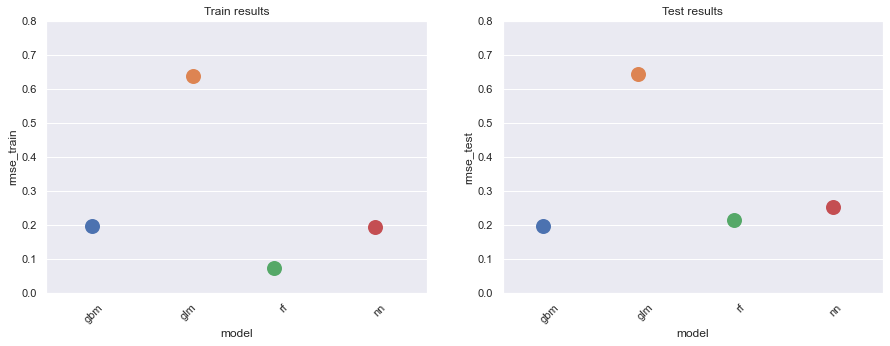

In [50]:
# Plot results for a graphical comparison
print("Spot Check Algorithms")
sns.set( rc = {'figure.figsize': (15, 5)})
plt.figure()
plt.subplot(1,2,1)  
sns.stripplot(x="model", y="rmse_train",data=score,size=15)
plt.xticks(rotation=45)
plt.title('Train results')
axes = plt.gca()
axes.set_ylim([0,0.8])
plt.subplot(1,2,2)
sns.stripplot(x="model", y="rmse_test",data=score,size=15)
plt.xticks(rotation=45)
plt.title('Test results')
axes = plt.gca()
axes.set_ylim([0,0.8])
plt.show()

Spot Check Algorithms


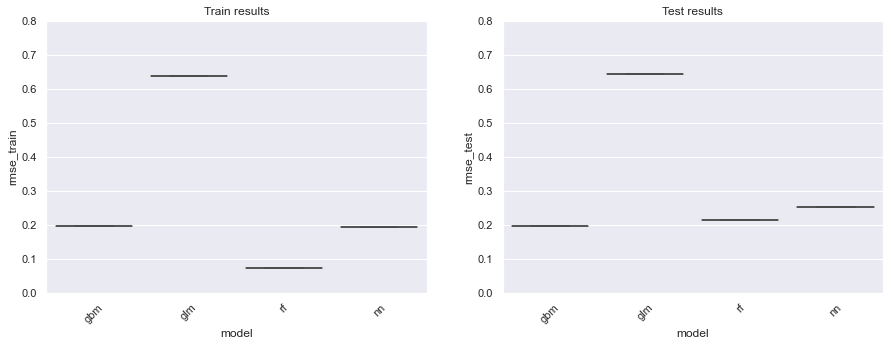

In [51]:
# Plot results for a graphical comparison
print("Spot Check Algorithms")
sns.set( rc = {'figure.figsize': (15, 5)})
plt.figure()
plt.subplot(1,2,1)  
sns.boxplot(x="model", y="rmse_train",data=score)
plt.xticks(rotation=45)
plt.title('Train results')
axes = plt.gca()
axes.set_ylim([0,0.8])
plt.subplot(1,2,2)
sns.boxplot(x="model", y="rmse_test",data=score)
plt.xticks(rotation=45)
plt.title('Test results')
axes = plt.gca()
axes.set_ylim([0,0.8])
plt.show()

In [52]:
test_df = all[all['Effective_Date'] >= '2011-10-01']
test_df = pd.concat([test_df, np.expm1(predictions_te_glm.set_index(test.index)), np.expm1(predictions_te_gbm.set_index(test.index)), 
                     np.expm1(predictions_te_rf.set_index(test.index)), np.expm1(predictions_te_nn.set_index(test.index))], axis=1)


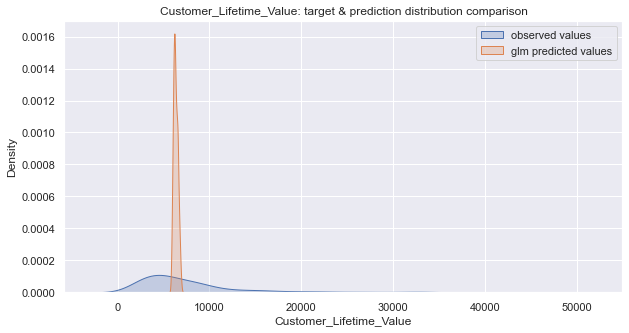

In [53]:
# Plot results
sns.set( rc = {'figure.figsize': (10, 5)})
fig,ax = plt.subplots(1, 1)
sns.kdeplot(x=test_df['Customer_Lifetime_Value'], fill=True, palette="crest", label="observed values",)
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_glm'], fill=True, palette="crest", label='glm predicted values')
plt.title('Customer_Lifetime_Value: target & prediction distribution comparison')
ax.legend()
plt.show()

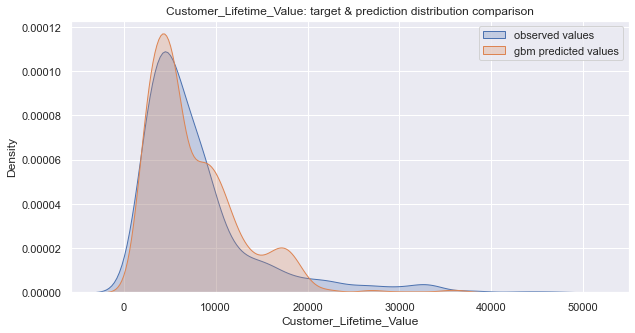

In [54]:
# Plot results
sns.set( rc = {'figure.figsize': (10, 5)})
fig,ax = plt.subplots(1, 1)
sns.kdeplot(x=test_df['Customer_Lifetime_Value'], fill=True, palette="crest", label="observed values",)
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_gbm'], fill=True, palette="crest", label='gbm predicted values')
plt.title('Customer_Lifetime_Value: target & prediction distribution comparison')
ax.legend()
plt.show()

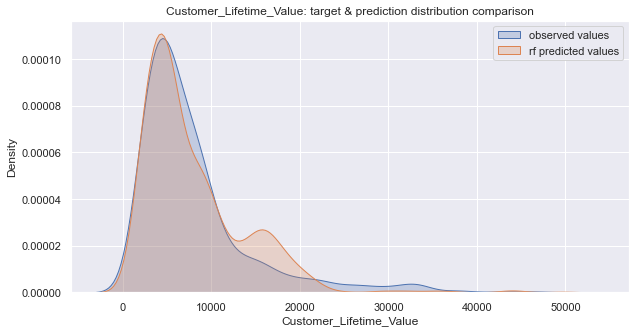

In [55]:
# Plot results
sns.set( rc = {'figure.figsize': (10, 5)})
fig,ax = plt.subplots(1, 1)
sns.kdeplot(x=test_df['Customer_Lifetime_Value'], fill=True, palette="crest", label="observed values",)
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_rf'], fill=True, palette="crest", label='rf predicted values')
plt.title('Customer_Lifetime_Value: target & prediction distribution comparison')
ax.legend()
plt.show()

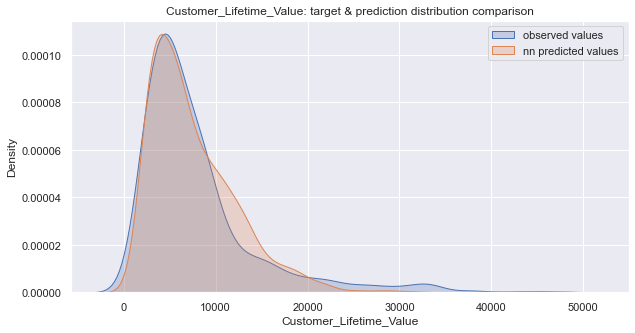

In [56]:
# Plot results
sns.set( rc = {'figure.figsize': (10, 5)})
fig,ax = plt.subplots(1, 1)
sns.kdeplot(x=test_df['Customer_Lifetime_Value'], fill=True, palette="crest", label="observed values",)
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict_nn'], fill=True, palette="crest", label='nn predicted values')
plt.title('Customer_Lifetime_Value: target & prediction distribution comparison')
ax.legend()
plt.show()